# MRD-BGPLVM for Melanoma Treg

General Setup

In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import numpy as np
import pandas as pd
import seaborn as sns
import GPy

/nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/nfs/team205/tpcg/bin/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/nfs/team205/tpcg/bin/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-p

In [2]:
def get_ard_params(m):
    return pd.DataFrame([b.input_sensitivity() for b in m.bgplvms], index=m.names)

def get_data_mel(dataset):
    res_mat = []
    for sub in ["cc", "other", "tissue"]:
        mat_treg = pd.read_csv("saved_data/SS2/Treg_mel_"+dataset+"_"+sub+".csv", 
                               header = 0, index_col = 0)
        t_c_cond = mat_treg.t_c_cond
        cc = mat_treg.cellcycle
        del mat_treg['t_c_cond']
        del mat_treg['cellcycle']
        cells = mat_treg.index
        
        res_mat.append(mat_treg.as_matrix())
        
    return res_mat, t_c_cond, cc, cells

Load data

In [3]:
dataset = "bLN_skin"
mat_list, t_c_cond, cc, cells = get_data_mel(dataset)

Run MRD-BGPLVM

In [4]:
# Set seed
np.random.seed(seed=1234)

# Run and optimize MRD
m_LNskinTreg = GPy.models.MRD(mat_list, input_dim=12, 
                              Ynames = ["cellcycle", "other", "tissue"], 
                              initx = "single") # default is concat
for b in m_LNskinTreg.bgplvms:
    b.likelihood.variance = .01 # this will force the function to be overfitted first and then relax the overfitting
m_LNskinTreg.optimize(messages=True, max_iters=25000)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    12s78  00009   1.566125e+06   7.731150e+10 
    24s33  00018   1.010721e+06   9.722355e+08 
    35s58  00027   9.589193e+05   7.267620e+08 
 01m22s00  00064   9.136655e+05   3.971765e+07 
 02m59s07  00142   9.054832e+05   1.048864e+06 
 08m15s93  00397   9.010035e+05   1.242964e+06 
 10m39s33  00513   9.002308e+05   2.951126e+07 
 29m21s76  01414   8.982836e+05   2.166311e+04 
 01h21m43  03933   8.973167e+05   1.127503e+05 
 01h55m54  05577   8.970969e+05   2.814652e+03 
 02h11m06  06311   8.970589e+05   3.477852e+02 
Runtime:  02h11m06
Optimization status: Converged



Look at output

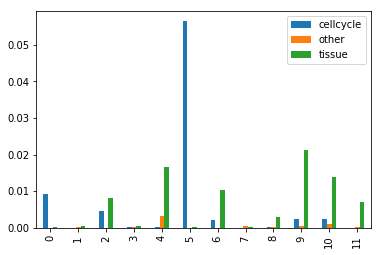

In [5]:
ard_params_LNskinTreg = get_ard_params(m_LNskinTreg)
ard_params_LNskinTreg.T.plot.bar()

 /nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


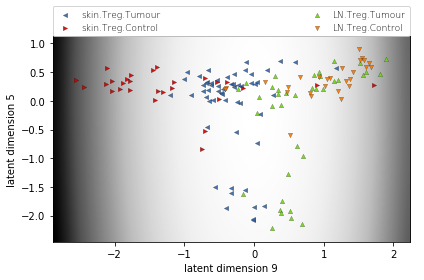

In [9]:
m_LNskinTreg.tissue.plot_latent(labels = t_c_cond, which_indices=[9,5])

Save data

In [10]:
lvmat_LNskinTreg = pd.DataFrame({"cell": pd.Series(list(cells), index=list(cells)),
                             "LV0": pd.Series(m_LNskinTreg.latent_space[:,0].mean, index=list(cells)),
                             "LV1": pd.Series(m_LNskinTreg.latent_space[:,1].mean, index=list(cells)),
                             "LV2": pd.Series(m_LNskinTreg.latent_space[:,2].mean, index=list(cells)),
                             "LV3": pd.Series(m_LNskinTreg.latent_space[:,3].mean, index=list(cells)),
                             "LV4": pd.Series(m_LNskinTreg.latent_space[:,4].mean, index=list(cells)),
                             "LV5": pd.Series(m_LNskinTreg.latent_space[:,5].mean, index=list(cells)),
                             "LV6": pd.Series(m_LNskinTreg.latent_space[:,6].mean, index=list(cells)),
                             "LV7": pd.Series(m_LNskinTreg.latent_space[:,7].mean, index=list(cells)),
                             "LV8": pd.Series(m_LNskinTreg.latent_space[:,8].mean, index=list(cells)),
                             "LV9": pd.Series(m_LNskinTreg.latent_space[:,9].mean, index=list(cells)),
                             "LV10": pd.Series(m_LNskinTreg.latent_space[:,10].mean, index=list(cells)),
                             "LV11": pd.Series(m_LNskinTreg.latent_space[:,11].mean, index=list(cells))
                             })
lvmat_LNskinTreg.to_csv("plots/SS2/MRD_melanoma/latent_variables_MRD_LNskinTreg.csv")
ard_params_LNskinTreg.to_csv("plots/SS2/MRD_melanoma/ARD_MRD_LNskinTreg.csv")

### BGPLVM for skin control and tumour individually

Functions

In [39]:
def get_ard_params(m):
    return pd.DataFrame(m.kern.input_sensitivity())

def get_lv(m, dat):
    latent_variables = pd.DataFrame({'cell': pd.Series(list(dat.index), index=list(dat.index)), 
    'LV0': pd.Series(m.latent_space[:, 0].mean, index=list(dat.index)), 
    'LV1': pd.Series(m.latent_space[:, 1].mean, index=list(dat.index)), 
    'LV2': pd.Series(m.latent_space[:, 2].mean, index=list(dat.index)),
    'LV3': pd.Series(m.latent_space[:, 3].mean, index=list(dat.index)),
    'LV4': pd.Series(m.latent_space[:, 4].mean, index=list(dat.index)),
    'LV5': pd.Series(m.latent_space[:, 5].mean, index=list(dat.index))})
    
    return latent_variables

def read_dataSS2(path):
    treg_mat = pd.read_csv(path, header = 0, index_col = 0)
    t_c_cond = treg_mat.t_c_cond
    cellcycle = treg_mat.cellcycle
    del treg_mat['t_c_cond']
    del treg_mat['cellcycle']
    treg_mat = treg_mat[[col for col in list(treg_mat) if col.startswith('ENS')]]
    
    return treg_mat, t_c_cond, cellcycle

def run_bgplvm(dat, dim = 6):
    np.random.seed(seed=1234)
    bgplvm = GPy.models.BayesianGPLVM(dat.as_matrix(), input_dim=dim)
    bgplvm.optimize(messages=True, max_iters=6000);
    
    return bgplvm

In [40]:
ctl_mat, ctl_tccond, ctl_cc = read_dataSS2("./saved_data/SS2/Treg_mel_bLN_skin_Control.csv")
tum_mat, tum_tccond, tum_cc = read_dataSS2("./saved_data/SS2/Treg_mel_bLN_skin_Tumour.csv")

In [42]:
bgplvm_ctl_6d = run_bgplvm(ctl_mat)
bgplvm_tum_6d = run_bgplvm(tum_mat)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s47  0008   6.522735e+05   1.112168e+10 
    07s79  0014   5.482992e+05   5.869028e+08 
    22s35  0040   5.289194e+05   4.526698e+07 
    29s03  0052   5.400013e+05   1.126308e+10 
 01m24s00  0150   5.270272e+05   1.916935e+04 
 01m33s04  0166   5.269241e+05   1.206818e+06 
 04m22s43  0467   5.262918e+05   2.389057e+05 
 06m56s44  0740   5.261638e+05   3.864601e+04 
 11m24s55  1223   5.261168e+05   4.168502e+03 
 11m55s55  1280   5.261161e+05   1.143112e+02 
Runtime:  11m55s55
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s67  0004   1.323160e+06   1.675544e+11 
    09s29  0014   7.185464e+05   3.150458e+08 
    11s95  0018   6.943299e+05   2.072102e+08 
    14s58  0022   6.810538e+05   1.083207e+07 
    27s90  0042   6.721537e+05   1.827570e+07 
    45s01  0068   6.698153e+05   1.101655e+06 
 02m08s54  01

 /nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
 /nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


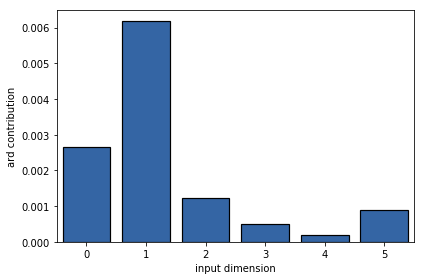

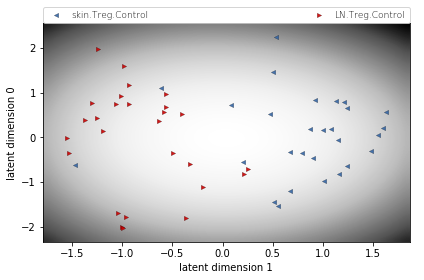

In [45]:
l_v = get_lv(bgplvm_ctl_6d, ctl_mat)
ard = get_ard_params(bgplvm_ctl_6d)
l_v.to_csv("./plots/SS2/MRD_melanoma/latent_variables_Treg_mel_bLN_skin_Control.csv")
ard.to_csv("./plots/SS2/MRD_melanoma/ARD_Treg_mel_bLN_skin_Control.csv")
bgplvm_ctl_6d.kern.plot_ARD();
bgplvm_ctl_6d.plot_latent(labels = ctl_tccond, which_indices=[1,0]);

 /nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
 /nfs/team205/tpcg/bin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


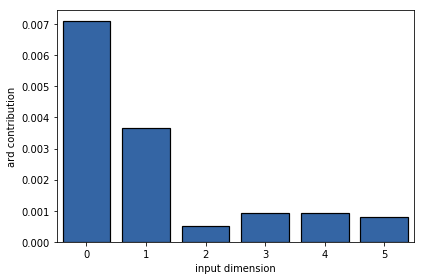

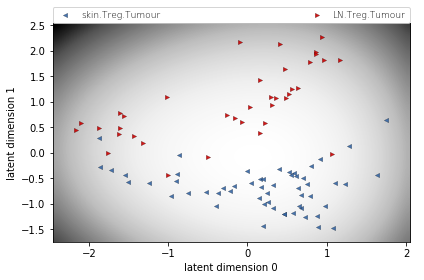

In [46]:
l_v = get_lv(bgplvm_tum_6d, tum_mat)
ard = get_ard_params(bgplvm_tum_6d)
l_v.to_csv("./plots/SS2/MRD_melanoma/latent_variables_Treg_mel_bLN_skin_Tumour.csv")
ard.to_csv("./plots/SS2/MRD_melanoma/ARD_Treg_mel_bLN_skin_Tumour.csv")
bgplvm_tum_6d.kern.plot_ARD();
bgplvm_tum_6d.plot_latent(labels = tum_tccond, which_indices=[0,1]);